Importing modules:-

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import dateutil
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
sns.set()

Loading Data:-

In [2]:
claims_path = "../Dataset/claims/"

In [3]:
claims = {}
claims_table_names = os.listdir(claims_path)
for x in claims_table_names:
    claims[x[:-4]] = pd.read_csv(claims_path+x,encoding = 'latin',low_memory=False)
claims.keys()

dict_keys(['beneficiary_summary_old', 'ben_inp', 'inpatient_claims', 'outpatient_claims'])

In [4]:
ben_inp = claims["ben_inp"].drop(columns = ["index"])
ben_inp.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,SP_STRKETIA,MEDREIMB_IP,BENRES_IP,PPPYMT_IP,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR
0,1EADDE572193B956,391071153936179,1,20090406.0,20090415.0,4506UA,5000.0,0.0,1.207675e+09,5.845177e+09,...,2,0.0,0.0,0.0,1000.0,150.0,0.0,3400.0,790.0,0.0
1,1EADDE572193B956,391111153943894,1,20081117.0,20081122.0,45T06G,5000.0,0.0,8.709346e+09,NaN,...,2,0.0,0.0,0.0,1000.0,150.0,0.0,3400.0,790.0,0.0
2,1EADDE572193B956,391881153933868,1,20081103.0,20081107.0,4500NJ,4000.0,0.0,3.653175e+09,3.653175e+09,...,2,0.0,0.0,0.0,1000.0,150.0,0.0,3400.0,790.0,0.0
3,1EADDE572193B956,391581153944476,1,20080211.0,20080214.0,4506UA,4000.0,0.0,5.845177e+09,9.156347e+09,...,2,0.0,0.0,0.0,1000.0,150.0,0.0,3400.0,790.0,0.0
4,1FAF1B7EC449A406,391881153927749,1,20081104.0,20081107.0,3302MC,13000.0,0.0,5.363290e+09,5.226557e+09,...,2,0.0,0.0,0.0,0.0,0.0,0.0,280.0,80.0,0.0


In [5]:
columns_bensum = [2,4,5]
required_columns = list(ben_inp.columns[[x+81 for x in columns_bensum]])
columns_inp = [7,8,12,14,15,16,17,19,13]+[x for x in range(21,31)]
required_columns.extend(ben_inp.columns[[ x -1 for x in columns_inp]])
print("Columns considered:-")
print(", ".join(required_columns),"\nnumber of coulmns = "+str(len(required_columns)))

Columns considered:-
BENE_BIRTH_DT, BENE_SEX_IDENT_CD, BENE_RACE_CD, CLM_PMT_AMT, NCH_PRMRY_PYR_CLM_PD_AMT, CLM_ADMSN_DT, CLM_PASS_THRU_PER_DIEM_AMT, NCH_BENE_IP_DDCTBL_AMT, NCH_BENE_PTA_COINSRNC_LBLTY_AM, NCH_BENE_BLOOD_DDCTBL_LBLTY_AM, NCH_BENE_DSCHRG_DT, ADMTNG_ICD9_DGNS_CD, ICD9_DGNS_CD_1, ICD9_DGNS_CD_2, ICD9_DGNS_CD_3, ICD9_DGNS_CD_4, ICD9_DGNS_CD_5, ICD9_DGNS_CD_6, ICD9_DGNS_CD_7, ICD9_DGNS_CD_8, ICD9_DGNS_CD_9, ICD9_DGNS_CD_10 
number of coulmns = 22


In [6]:
df = ben_inp[["DESYNPUF_ID"]+required_columns+["CLM_UTLZTN_DAY_CNT"]]
df.iloc[:,12:24].head()

,ADMTNG_ICD9_DGNS_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,CLM_UTLZTN_DAY_CNT
0,78650,486,20500,78841,42611,73300,40390,25000,79902,V5866,NaN,9.0
1,49121,49320,V4581,311,4019,4254,56409,2761,V5866,41401,NaN,5.0
2,27650,27651,25002,2769,40390,42731,2767,41400,41401,42789,NaN,4.0
3,586,5849,25042,7960,V4501,5859,2767,71590,V5867,4241,NaN,3.0
4,8208,82022,42731,E8889,5939,2859,53081,41401,2851,56400,NaN,3.0


In [7]:
## df.iloc[:,13:].head()
def return_func(row):
    try:
        for x in row:
            num = int(x[:3])
            if (num >= 410) & (num<=414):
                return True
        return False
    except:
        return False
df_ischemic = df[df.loc[:,"ADMTNG_ICD9_DGNS_CD":"ICD9_DGNS_CD_10"].apply(return_func,axis=1)].drop(columns = df.loc[:,"ADMTNG_ICD9_DGNS_CD":"ICD9_DGNS_CD_10"].columns)
df_ischemic.head()

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,CLM_ADMSN_DT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_BENE_DSCHRG_DT,CLM_UTLZTN_DAY_CNT
2,1EADDE572193B956,19411101,2,1,4000.0,0.0,20081103,0.0,1024.0,0.0,0.0,20081107,4.0
7,216C2BA9AB57CC61,19330701,1,1,4000.0,0.0,20080913,0.0,1024.0,0.0,0.0,20080917,4.0
8,22B5C5BC772C32A5,19320201,1,1,11000.0,0.0,20090718,0.0,1068.0,0.0,0.0,20090720,2.0
14,27584D29C341FB19,19420701,2,1,4000.0,0.0,20091002,0.0,1068.0,0.0,0.0,20091005,3.0
17,28314AB0026522E2,19390201,1,1,6000.0,0.0,20091107,80.0,1068.0,0.0,0.0,20091107,1.0


In [8]:
df_ischemic.columns

Index(['DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD',
       'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'CLM_ADMSN_DT',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'NCH_BENE_DSCHRG_DT', 'CLM_UTLZTN_DAY_CNT'],
      dtype='object')

In [9]:
def days_to_years( number_of_days ):
    return int(number_of_days / 365) 
df_ischemic.BENE_BIRTH_DT = pd.to_datetime(df_ischemic.BENE_BIRTH_DT,format="%Y%m%d")
df_ischemic.CLM_ADMSN_DT = pd.to_datetime(df_ischemic.CLM_ADMSN_DT,format="%Y%m%d")
df_ischemic.NCH_BENE_DSCHRG_DT = pd.to_datetime(df_ischemic.NCH_BENE_DSCHRG_DT,format="%Y%m%d")
df_ischemic["AGE"] = (df_ischemic.CLM_ADMSN_DT - df_ischemic.BENE_BIRTH_DT).dt.days.apply(days_to_years)
df_ischemic["LENGTH_OF_STAY"] = (df_ischemic.NCH_BENE_DSCHRG_DT - df_ischemic.CLM_ADMSN_DT ).dt.days

In [10]:
race_list = {1:"WHITE",2:"BLACK",3:"OTHERS",5:"HISPANIC"}
def code_to_race(val):
    return race_list[val]
def code_to_gender(x):
    if x==1:
        return "Male"
    return "Female"
df_ischemic['GENDER'] = df_ischemic.BENE_SEX_IDENT_CD.apply(code_to_gender)
df_ischemic["RACE"] = df_ischemic.BENE_RACE_CD.apply(code_to_race)
df_ischemic.head()

,DESYNPUF_ID,BENE_BIRTH_DT,BENE_SEX_IDENT_CD,BENE_RACE_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,CLM_ADMSN_DT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_BENE_DSCHRG_DT,CLM_UTLZTN_DAY_CNT,AGE,LENGTH_OF_STAY,GENDER,RACE
2,1EADDE572193B956,1941-11-01,2,1,4000.0,0.0,2008-11-03,0.0,1024.0,0.0,0.0,2008-11-07,4.0,67,4,Female,WHITE
7,216C2BA9AB57CC61,1933-07-01,1,1,4000.0,0.0,2008-09-13,0.0,1024.0,0.0,0.0,2008-09-17,4.0,75,4,Male,WHITE
8,22B5C5BC772C32A5,1932-02-01,1,1,11000.0,0.0,2009-07-18,0.0,1068.0,0.0,0.0,2009-07-20,2.0,77,2,Male,WHITE
14,27584D29C341FB19,1942-07-01,2,1,4000.0,0.0,2009-10-02,0.0,1068.0,0.0,0.0,2009-10-05,3.0,67,3,Female,WHITE
17,28314AB0026522E2,1939-02-01,1,1,6000.0,0.0,2009-11-07,80.0,1068.0,0.0,0.0,2009-11-07,1.0,70,0,Male,WHITE


In [11]:
df_ischemic["MEDREIMB_IP"] = df_ischemic.CLM_PMT_AMT + df_ischemic.CLM_UTLZTN_DAY_CNT*df_ischemic.CLM_PASS_THRU_PER_DIEM_AMT
df_ischemic["BENRES_IP"] = df_ischemic.NCH_BENE_IP_DDCTBL_AMT+ df_ischemic.NCH_BENE_PTA_COINSRNC_LBLTY_AM + df_ischemic.NCH_BENE_BLOOD_DDCTBL_LBLTY_AM
df_ischemic["PPPYMT_IP"] = df_ischemic.NCH_PRMRY_PYR_CLM_PD_AMT
df_ischemic["TOTAL_COST"] = df_ischemic.MEDREIMB_IP + df_ischemic.PPPYMT_IP + df_ischemic.BENRES_IP
df_ischemic["PAYABLE"] = df_ischemic.BENRES_IP
df_ischemic["RATIO"] = df_ischemic.PAYABLE / df_ischemic.TOTAL_COST
df_ischemic["GAP"] = df_ischemic.TOTAL_COST - df_ischemic.PAYABLE
df_ischemic_costs = df_ischemic.drop(columns=["BENE_SEX_IDENT_CD","BENE_RACE_CD","BENE_BIRTH_DT","CLM_ADMSN_DT","NCH_BENE_DSCHRG_DT","CLM_UTLZTN_DAY_CNT","MEDREIMB_IP","BENRES_IP","PPPYMT_IP","CLM_PMT_AMT","NCH_PRMRY_PYR_CLM_PD_AMT","CLM_PASS_THRU_PER_DIEM_AMT","NCH_BENE_IP_DDCTBL_AMT","NCH_BENE_PTA_COINSRNC_LBLTY_AM","NCH_BENE_BLOOD_DDCTBL_LBLTY_AM"])
###
del(df_ischemic)
del(df)
###
df_ischemic_costs.dropna(inplace=True)
df_ischemic_costs.head()

,DESYNPUF_ID,AGE,LENGTH_OF_STAY,GENDER,RACE,TOTAL_COST,PAYABLE,RATIO,GAP
2,1EADDE572193B956,67,4,Female,WHITE,5024.0,1024.0,0.203822,4000.0
7,216C2BA9AB57CC61,75,4,Male,WHITE,5024.0,1024.0,0.203822,4000.0
8,22B5C5BC772C32A5,77,2,Male,WHITE,12068.0,1068.0,0.088499,11000.0
14,27584D29C341FB19,67,3,Female,WHITE,5068.0,1068.0,0.210734,4000.0
17,28314AB0026522E2,70,0,Male,WHITE,7148.0,1068.0,0.149412,6080.0


Univariate :-

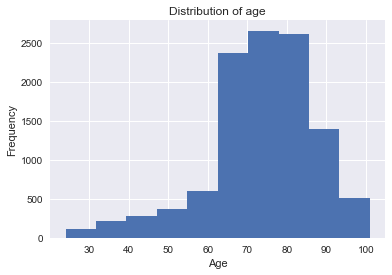

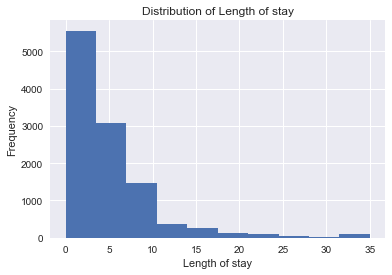

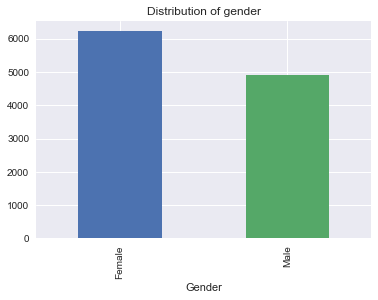

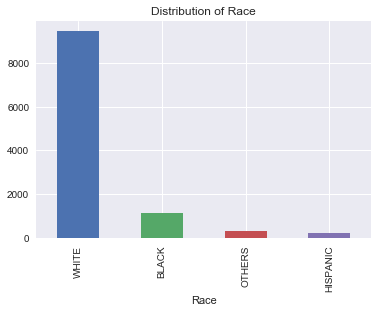

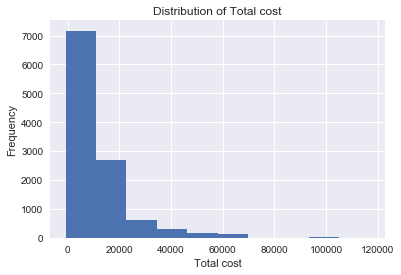

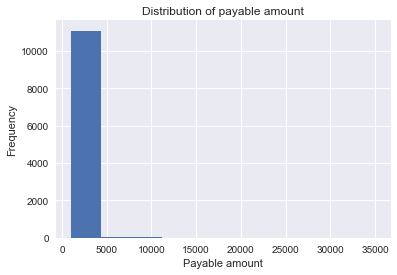

In [12]:
df_ischemic_costs.AGE.plot.hist()
plt.xlabel("Age")
plt.title("Distribution of age")
plt.show()

df_ischemic_costs.LENGTH_OF_STAY.plot.hist()
plt.xlabel("Length of stay")
plt.title("Distribution of Length of stay")
plt.show()

df_ischemic_costs.GENDER.value_counts().plot.bar()
plt.title("Distribution of gender")
plt.xlabel("Gender")
plt.show()

df_ischemic_costs.RACE.value_counts().plot.bar()
plt.title("Distribution of Race")
plt.xlabel("Race")
plt.show()

df_ischemic_costs.TOTAL_COST.plot.hist()
plt.title("Distribution of Total cost")
plt.xlabel("Total cost")
plt.show()

df_ischemic_costs.PAYABLE.plot.hist()
plt.title("Distribution of payable amount")
plt.xlabel("Payable amount")
#plt.xlim(0,5000)
plt.show()

Bivariate:-

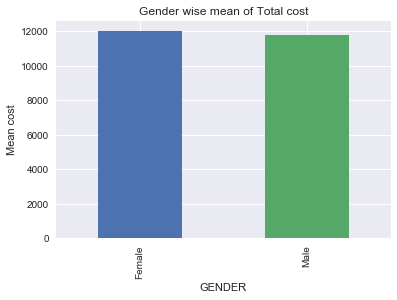

In [13]:
df_ischemic_costs.groupby("GENDER").TOTAL_COST.mean().plot.bar()
plt.ylabel("Mean cost")
plt.title("Gender wise mean of Total cost")
plt.show()

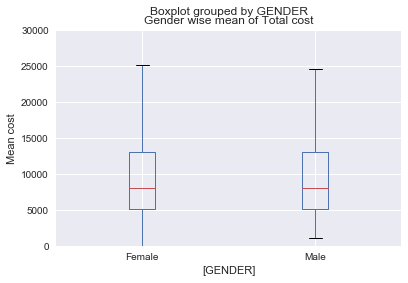

In [14]:
df_ischemic_costs[["GENDER","TOTAL_COST"]].boxplot(by="GENDER")
plt.ylabel("Mean cost")
plt.title("Gender wise mean of Total cost")
plt.ylim(0,30000)
plt.show()

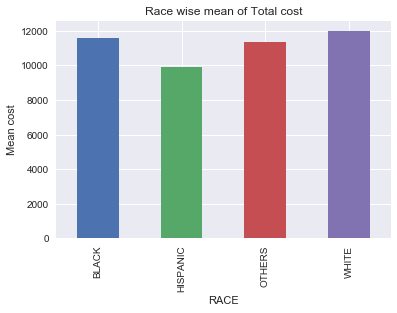

In [15]:
df_ischemic_costs.groupby("RACE").TOTAL_COST.mean().plot.bar()
plt.ylabel("Mean cost")
plt.title("Race wise mean of Total cost")
plt.show()

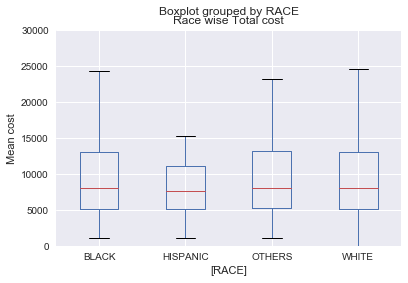

In [16]:
df_ischemic_costs[["RACE","TOTAL_COST"]].boxplot(by="RACE")
plt.ylabel("Mean cost")
plt.title("Race wise Total cost")
plt.ylim(0,30000)
plt.show()

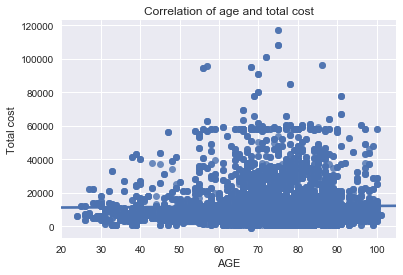

In [17]:
sns.regplot(x="AGE", y="TOTAL_COST", data=df_ischemic_costs)
plt.title("Correlation of age and total cost")
plt.ylabel("Total cost")
plt.show()

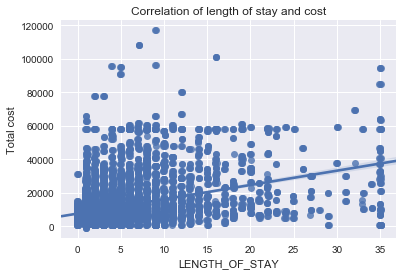

In [18]:
sns.regplot(x="LENGTH_OF_STAY", y="TOTAL_COST",x_jitter=0.1, data=df_ischemic_costs)
plt.title("Correlation of length of stay and cost")
plt.ylabel("Total cost")
plt.show()

Effect of a third variable:-

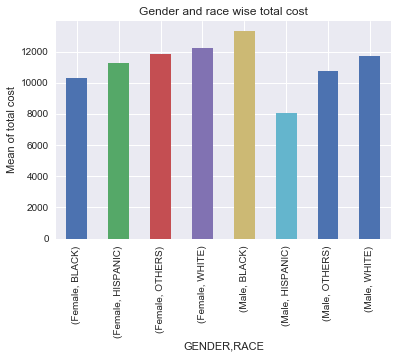

'df_ischemic_costs.groupby(["GENDER","RACE"]).PAYABLE.mean().plot.bar()\nplt.title("Gender and race wise payable cost")\nplt.ylabel("Mean of payable cost")\nplt.show()'

In [19]:
df_ischemic_costs.groupby(["GENDER","RACE"]).TOTAL_COST.mean().plot.bar()
plt.title("Gender and race wise total cost")
plt.ylabel("Mean of total cost")
plt.show()
'''df_ischemic_costs.groupby(["GENDER","RACE"]).PAYABLE.mean().plot.bar()
plt.title("Gender and race wise payable cost")
plt.ylabel("Mean of payable cost")
plt.show()'''

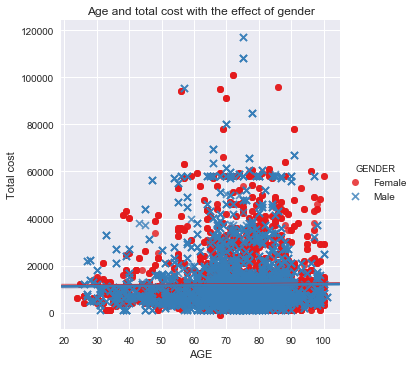

In [20]:
sns.lmplot(x="AGE", y="TOTAL_COST", hue="GENDER", data=df_ischemic_costs,markers=["o", "x"],palette="Set1")
plt.title("Age and total cost with the effect of gender")
plt.ylabel("Total cost")
plt.show()

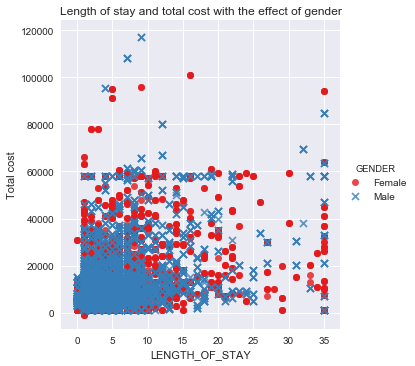

In [21]:
sns.lmplot(x="LENGTH_OF_STAY", y="TOTAL_COST", hue="GENDER", data=df_ischemic_costs,markers=["o", "x"],palette="Set1",fit_reg=False)
plt.title("Length of stay and total cost with the effect of gender")
plt.ylabel("Total cost")
plt.show()

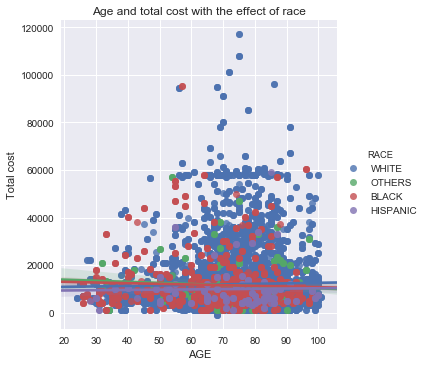

In [22]:
sns.lmplot(x="AGE", y="TOTAL_COST", hue="RACE", data=df_ischemic_costs)
plt.title("Age and total cost with the effect of race")
plt.ylabel("Total cost")
plt.show()

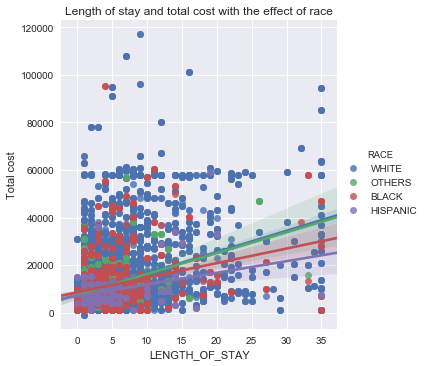

In [23]:
sns.lmplot(x="LENGTH_OF_STAY", y="TOTAL_COST", hue="RACE", data=df_ischemic_costs)
plt.title("Length of stay and total cost with the effect of race")
plt.ylabel("Total cost")
plt.show()

Making age groups for the individuals

In [24]:
_,bins_edges = np.histogram(df_ischemic_costs.AGE,bins='fd')
bins_edges,len(bins_edges)

(array([ 24.        ,  25.24193548,  26.48387097,  27.72580645,
         28.96774194,  30.20967742,  31.4516129 ,  32.69354839,
         33.93548387,  35.17741935,  36.41935484,  37.66129032,
         38.90322581,  40.14516129,  41.38709677,  42.62903226,
         43.87096774,  45.11290323,  46.35483871,  47.59677419,
         48.83870968,  50.08064516,  51.32258065,  52.56451613,
         53.80645161,  55.0483871 ,  56.29032258,  57.53225806,
         58.77419355,  60.01612903,  61.25806452,  62.5       ,
         63.74193548,  64.98387097,  66.22580645,  67.46774194,
         68.70967742,  69.9516129 ,  71.19354839,  72.43548387,
         73.67741935,  74.91935484,  76.16129032,  77.40322581,
         78.64516129,  79.88709677,  81.12903226,  82.37096774,
         83.61290323,  84.85483871,  86.09677419,  87.33870968,
         88.58064516,  89.82258065,  91.06451613,  92.30645161,
         93.5483871 ,  94.79032258,  96.03225806,  97.27419355,
         98.51612903,  99.75806452, 101.

Freedman–Diaconis rule gives too large values for bins. Reducing them to 10 for easier analysis

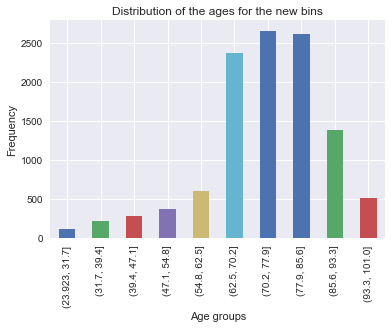

In [25]:
num_age_groups = 10

'''#bins = pd.IntervalIndex.from_tuples([(0,60),(60, 90),(90, 110)])
#df_ischemic_costs["AGE_BINS"] = pd.cut(df_ischemic_costs.AGE,bins=bins)'''

df_ischemic_costs["AGE_BINS"] = pd.cut(df_ischemic_costs.AGE,bins=num_age_groups)
df_ischemic_costs.AGE_BINS.value_counts(sort=False).plot.bar()
plt.title("Distribution of the ages for the new bins")
plt.ylabel("Frequency")
plt.xlabel("Age groups")
plt.show()

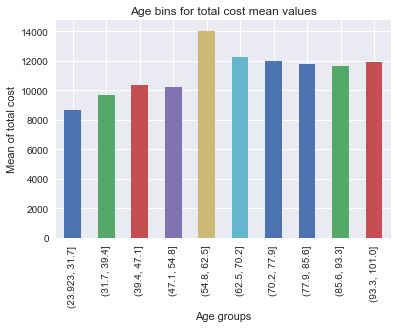

In [26]:
df_ischemic_costs.groupby("AGE_BINS").TOTAL_COST.mean().plot.bar()
plt.title("Age bins for total cost mean values")
plt.ylabel("Mean of total cost")
plt.xlabel("Age groups")
plt.show()

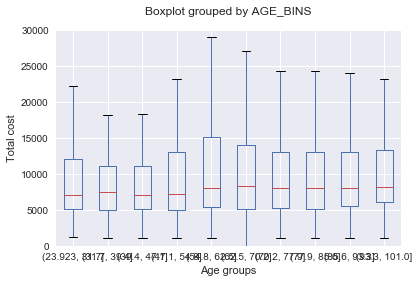

In [27]:
df_ischemic_costs[["AGE_BINS","TOTAL_COST"]].boxplot(by="AGE_BINS")
#plt.title("Age bins for total cost distribution")
plt.title("")
plt.ylabel("Total cost")
plt.xlabel("Age groups")
plt.ylim(0,30000)
plt.show()

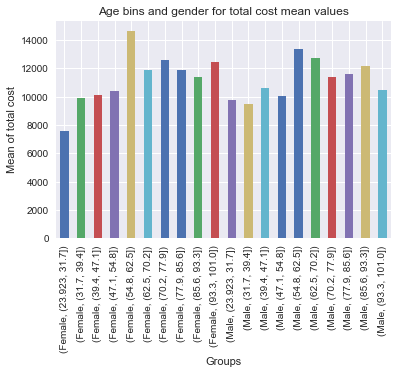

In [28]:
df_ischemic_costs.groupby(["GENDER","AGE_BINS"]).TOTAL_COST.mean().plot.bar()
plt.title("Age bins and gender for total cost mean values")
plt.ylabel("Mean of total cost")
plt.xlabel("Groups")
plt.show()

In [29]:
_,num_length_groups = np.histogram(df_ischemic_costs.LENGTH_OF_STAY,bins = 'fd')
num_length_groups

array([ 0.        ,  0.35714286,  0.71428571,  1.07142857,  1.42857143,
        1.78571429,  2.14285714,  2.5       ,  2.85714286,  3.21428571,
        3.57142857,  3.92857143,  4.28571429,  4.64285714,  5.        ,
        5.35714286,  5.71428571,  6.07142857,  6.42857143,  6.78571429,
        7.14285714,  7.5       ,  7.85714286,  8.21428571,  8.57142857,
        8.92857143,  9.28571429,  9.64285714, 10.        , 10.35714286,
       10.71428571, 11.07142857, 11.42857143, 11.78571429, 12.14285714,
       12.5       , 12.85714286, 13.21428571, 13.57142857, 13.92857143,
       14.28571429, 14.64285714, 15.        , 15.35714286, 15.71428571,
       16.07142857, 16.42857143, 16.78571429, 17.14285714, 17.5       ,
       17.85714286, 18.21428571, 18.57142857, 18.92857143, 19.28571429,
       19.64285714, 20.        , 20.35714286, 20.71428571, 21.07142857,
       21.42857143, 21.78571429, 22.14285714, 22.5       , 22.85714286,
       23.21428571, 23.57142857, 23.92857143, 24.28571429, 24.64

Freedman–Diaconis rule gives too large number of bins. Reducing them to 10 for easier analysis

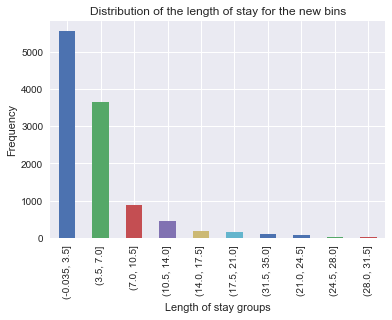

In [30]:
num_length_groups = 10
df_ischemic_costs["LENGTH_OF_STAY_BINS"] = pd.cut(df_ischemic_costs.LENGTH_OF_STAY,num_length_groups)
df_ischemic_costs.LENGTH_OF_STAY_BINS.value_counts().plot.bar()
plt.title("Distribution of the length of stay for the new bins")
plt.ylabel("Frequency")
plt.xlabel("Length of stay groups")
plt.show()

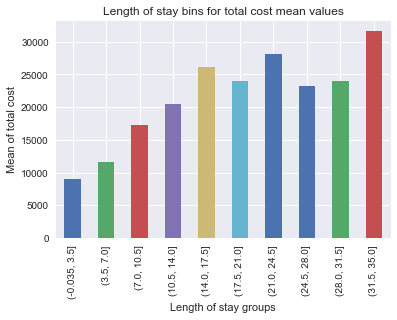

In [31]:
df_ischemic_costs.groupby("LENGTH_OF_STAY_BINS").TOTAL_COST.mean().plot.bar()
plt.title("Length of stay bins for total cost mean values")
plt.ylabel("Mean of total cost")
plt.xlabel("Length of stay groups")
plt.show()

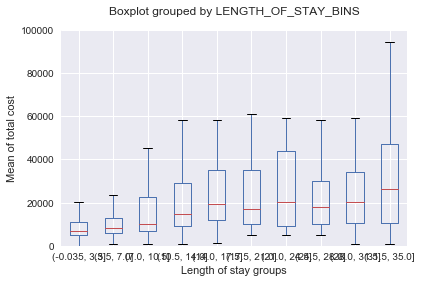

In [32]:
df_ischemic_costs[["LENGTH_OF_STAY_BINS","TOTAL_COST"]].boxplot(by="LENGTH_OF_STAY_BINS")
#plt.title("Length of stay bins for total cost mean values")
plt.title("")
plt.ylabel("Mean of total cost")
plt.xlabel("Length of stay groups")
plt.ylim(0,100000)
plt.show()

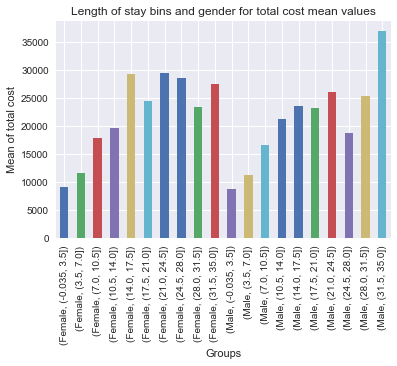

In [33]:
df_ischemic_costs.groupby(["GENDER","LENGTH_OF_STAY_BINS"]).TOTAL_COST.mean().plot.bar()
plt.title("Length of stay bins and gender for total cost mean values")
plt.ylabel("Mean of total cost")
plt.xlabel("Groups")
plt.show()

In [34]:
df_ischemic_costs.head()

,DESYNPUF_ID,AGE,LENGTH_OF_STAY,GENDER,RACE,TOTAL_COST,PAYABLE,RATIO,GAP,AGE_BINS,LENGTH_OF_STAY_BINS
2,1EADDE572193B956,67,4,Female,WHITE,5024.0,1024.0,0.203822,4000.0,"(62.5, 70.2]","(3.5, 7.0]"
7,216C2BA9AB57CC61,75,4,Male,WHITE,5024.0,1024.0,0.203822,4000.0,"(70.2, 77.9]","(3.5, 7.0]"
8,22B5C5BC772C32A5,77,2,Male,WHITE,12068.0,1068.0,0.088499,11000.0,"(70.2, 77.9]","(-0.035, 3.5]"
14,27584D29C341FB19,67,3,Female,WHITE,5068.0,1068.0,0.210734,4000.0,"(62.5, 70.2]","(-0.035, 3.5]"
17,28314AB0026522E2,70,0,Male,WHITE,7148.0,1068.0,0.149412,6080.0,"(62.5, 70.2]","(-0.035, 3.5]"


# Statistical tests:-

In [35]:
import scipy.stats as stats
x = stats.norm.rvs(size = 100)
#print("Total cost is not a normally distributed value\n")
stats.normaltest(df_ischemic_costs.TOTAL_COST)

NormaltestResult(statistic=6916.845632321406, pvalue=0.0)

The total cost is not a normally distributed value. Hence we cannot use anova to compare categorical independent variable and a quantative resopnse variable. The non Parametric tests are done below:-

In [36]:
cols = list(df_ischemic_costs.columns)
cols = cols[:5]+cols[9:]+cols[5:9]
df_ischemic_costs = df_ischemic_costs[cols]
del(cols)
df_ischemic_costs.head()

,DESYNPUF_ID,AGE,LENGTH_OF_STAY,GENDER,RACE,AGE_BINS,LENGTH_OF_STAY_BINS,TOTAL_COST,PAYABLE,RATIO,GAP
2,1EADDE572193B956,67,4,Female,WHITE,"(62.5, 70.2]","(3.5, 7.0]",5024.0,1024.0,0.203822,4000.0
7,216C2BA9AB57CC61,75,4,Male,WHITE,"(70.2, 77.9]","(3.5, 7.0]",5024.0,1024.0,0.203822,4000.0
8,22B5C5BC772C32A5,77,2,Male,WHITE,"(70.2, 77.9]","(-0.035, 3.5]",12068.0,1068.0,0.088499,11000.0
14,27584D29C341FB19,67,3,Female,WHITE,"(62.5, 70.2]","(-0.035, 3.5]",5068.0,1068.0,0.210734,4000.0
17,28314AB0026522E2,70,0,Male,WHITE,"(62.5, 70.2]","(-0.035, 3.5]",7148.0,1068.0,0.149412,6080.0


For testing the correlation between the quantative age variable and the total cost, we use the pearson correlation test to find if there is a linear relationship

In [37]:
cor,p_value = scipy.stats.pearsonr(df_ischemic_costs["TOTAL_COST"],df_ischemic_costs["AGE"])
print("Pearson correlation value : ",cor,", P value : ",p_value)

Pearson correlation value :  0.013583349449493081 , P value :  0.15202444905888418


Here, the p value is greater than 0.05 which means we cannot reject the null hypothesis

For testing the correlation between the quantative length of stay variable and the total cost, we use the pearson correlation test to find if there is a linear relationship

In [38]:
cor,p_value = scipy.stats.pearsonr(df_ischemic_costs["TOTAL_COST"],df_ischemic_costs["LENGTH_OF_STAY"])
print("Pearson correlation value : ",cor,", P value : ",p_value)

Pearson correlation value :  0.3683866018676269 , P value :  0.0


Here, the p value is less than 0.05 which means we can reject the null hypothesis. There is a linear correlation between length of stay and total cost

Gender and total cost correlation:-

Since the independent variable is a categorical variable and dependent variable is a quantative non normally distributed variable, we use the kruskal wallis test to see if there is a difference in the median of the total cost in the two different genders.

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA

In [39]:
scipy.stats.kruskal(df_ischemic_costs[df_ischemic_costs.GENDER == "Male"].TOTAL_COST,df_ischemic_costs[df_ischemic_costs.GENDER=="Female"].TOTAL_COST)

KruskalResult(statistic=1.4676839495176714, pvalue=0.22571147008262563)

The kruskal wallis test has a p value>0.05 , hence we accept the null hypothesis

RACE and total cost correlation:-

Similarly we test the correlation of race with the total cost

In [40]:
gp = df_ischemic_costs.groupby('RACE')
groups = pd.unique(df_ischemic_costs["RACE"])
data = [df_ischemic_costs[df_ischemic_costs.RACE == grp].TOTAL_COST for grp in groups]
scipy.stats.kruskal(*data)

KruskalResult(statistic=3.4066357466847172, pvalue=0.3330745518625856)

The kruskal wallis test has a p value>0.05 , hence we accept the null hypothesis

Age bins and total cost correlation:-

Similarly we test the correlation of age with the total cost

In [41]:
gp = df_ischemic_costs.groupby('AGE_BINS')
groups = pd.unique(df_ischemic_costs["AGE_BINS"])
data = [df_ischemic_costs[df_ischemic_costs.AGE_BINS == grp].TOTAL_COST for grp in groups]
scipy.stats.kruskal(*data)

KruskalResult(statistic=30.39207469451556, pvalue=0.0003761572926760959)

The kruskal wallis test has a p value<0.05 , hence we reject the null hypothesis

To see which groups are significantly different:-

In [42]:
gp = df_ischemic_costs.groupby('AGE_BINS')
groups = pd.unique(df_ischemic_costs["AGE_BINS"])
data =[]
for i in range(len(groups)):
    for j in range(i+1,len(groups)):
        data.append([groups[i],groups[j]])
for x in range(len(data)):
    a,b = data[x]
    a = df_ischemic_costs[df_ischemic_costs.AGE_BINS == a].TOTAL_COST
    b = df_ischemic_costs[df_ischemic_costs.AGE_BINS == b].TOTAL_COST
    data[x].append([a,b])
mat = []
for x in data:
    left,right,vals = x
    stat,pval = scipy.stats.kruskal(*vals)
    if pval < 0.05:
        reject = True
    else:
        reject = False
    mat.append([left,right,stat,pval,reject])
pd.DataFrame(mat,columns="left,right,stat,p-value,reject".split(','))

,left,right,stat,p-value,reject
0,"(62.5, 70.2]","(70.2, 77.9]",0.634045,0.425875,False
1,"(62.5, 70.2]","(77.9, 85.6]",8.838540,0.002949,True
2,"(62.5, 70.2]","(85.6, 93.3]",0.767299,0.381054,False
3,"(62.5, 70.2]","(31.7, 39.4]",8.977825,0.002733,True
4,"(62.5, 70.2]","(93.3, 101.0]",0.099652,0.752247,False
5,"(62.5, 70.2]","(47.1, 54.8]",4.780122,0.028790,True
6,"(62.5, 70.2]","(54.8, 62.5]",0.744370,0.388265,False
7,"(62.5, 70.2]","(39.4, 47.1]",4.502829,0.033839,True
8,"(62.5, 70.2]","(23.923, 31.7]",4.650179,0.031050,True
9,"(70.2, 77.9]","(77.9, 85.6]",5.730743,0.016670,True


Length of stay and total cost correlation:-

Similarly we test the correlation of Length of stay with the total cost

In [43]:
gp = df_ischemic_costs.groupby('LENGTH_OF_STAY_BINS')
groups = pd.unique(df_ischemic_costs["LENGTH_OF_STAY_BINS"])
data = [df_ischemic_costs[df_ischemic_costs.LENGTH_OF_STAY_BINS == grp].TOTAL_COST for grp in groups]
scipy.stats.kruskal(*data)

KruskalResult(statistic=1076.827010987405, pvalue=4.635261357891843e-226)

The kruskal wallis test has a p value<0.05 , hence we reject the null hypothesis

To see which groups are significantly different:-

In [44]:
groups = pd.unique(df_ischemic_costs["LENGTH_OF_STAY_BINS"])
data =[]
for i in range(len(groups)):
    for j in range(i+1,len(groups)):
        data.append([groups[i],groups[j]])
for x in range(len(data)):
    a,b = data[x]
    a = df_ischemic_costs[df_ischemic_costs.LENGTH_OF_STAY_BINS == a].TOTAL_COST
    b = df_ischemic_costs[df_ischemic_costs.LENGTH_OF_STAY_BINS == b].TOTAL_COST
    data[x].append([a,b])
mat = []
for x in data:
    left,right,vals = x
    stat,pval = scipy.stats.kruskal(*vals)
    if pval < 0.05:
        reject = True
    else:
        reject = False
    mat.append([left,right,stat,pval,reject])
pd.DataFrame(mat,columns="left,right,stat,p-value,reject".split(','))

,left,right,stat,p-value,reject
0,"(3.5, 7.0]","(-0.035, 3.5]",149.431692,2.307703e-34,True
1,"(3.5, 7.0]","(10.5, 14.0]",200.827071,1.378314e-45,True
2,"(3.5, 7.0]","(14.0, 17.5]",145.684197,1.521881e-33,True
3,"(3.5, 7.0]","(7.0, 10.5]",93.340281,4.403385e-22,True
4,"(3.5, 7.0]","(24.5, 28.0]",33.679268,6.498966e-09,True
5,"(3.5, 7.0]","(28.0, 31.5]",12.181505,4.826568e-04,True
6,"(3.5, 7.0]","(17.5, 21.0]",106.487493,5.765523e-25,True
7,"(3.5, 7.0]","(31.5, 35.0]",68.047614,1.595948e-16,True
8,"(3.5, 7.0]","(21.0, 24.5]",68.386919,1.343660e-16,True
9,"(-0.035, 3.5]","(10.5, 14.0]",354.219888,5.107573e-79,True


Saving this dataset for combining with the ehr dataset:-